In [1]:
import torch
import matplotlib.pyplot as plt
import warnings
def warn(*args, **kwargs):
    pass
warnings.warn = warn
warnings.filterwarnings('ignore')

import json
import numpy as np

from datasets import load_dataset, load_metric
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model, TaskType, replace_lora_weights_loftq, prepare_model_for_kbit_training

In [2]:
# Move the model to the appropriate device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# help functions
def save_to_json(data, file_path):
    """
    Save a dictionary to a JSON file.

    Args:
        data (dict): The dictionary to save.
        file_path (str): The path to the JSON file.
    """
    with open(file_path, 'w') as json_file:
        json.dump(data, json_file, indent=4)
    print(f"Data successfully saved to {file_path}")
    
    
def load_from_json(file_path):
    """
    Load data from a JSON file.

    Args:
        file_path (str): The path to the JSON file.

    Returns:
        dict: The data loaded from the JSON file.
    """
    with open(file_path, 'r') as json_file:
        data = json.load(json_file)
    return data   

In [4]:
# Load IMDB dataset
imdb = load_dataset("imdb")

In [5]:
train_labels = imdb['train']['label']
unique_labels = set(train_labels)
print("\nUnique labels in the dataset (class information):")
print(unique_labels)


Unique labels in the dataset (class information):
{0, 1}


In [6]:
class_names = {0: "negative", 1: "positive"}

In [7]:
train_dataset = imdb["train"].shuffle(seed=42)
test_dataset = imdb["test"].shuffle(seed=42)
print(f"No. of training sample: {len(train_dataset)}")
print(f"No. of testing sample: {len(test_dataset)}")

No. of training sample: 25000
No. of testing sample: 25000


In [8]:
# Tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
def preprocess_function(examples):
    return tokenizer(examples["text"], padding=True, truncation=True, max_length=512)

tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_test = test_dataset.map(preprocess_function, batched=True)

In [9]:
def compute_metrics(eval_pred):
   load_accuracy = load_metric("accuracy", trust_remote_code=True)

  
   logits, labels = eval_pred
   predictions = np.argmax(logits, axis=-1)
   accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]

   return {"accuracy": accuracy}

In [10]:
# Configure BitsAndBytes
config_bnb = BitsAndBytesConfig(
    load_in_4bit=True, # quantize the model to 4-bits when you load it
    bnb_4bit_quant_type="nf4", # use a special 4-bit data type for weights initialized from a normal distribution
    bnb_4bit_use_double_quant=True, # nested quantization scheme to quantize the already quantized weights
    bnb_4bit_compute_dtype=torch.bfloat16, # use bfloat16 for faster computation
    llm_int8_skip_modules=["classifier", "pre_classifier"] #  Don't convert the "classifier" and "pre_classifier" layers to 8-bit
)

In [11]:
device

device(type='cuda')

In [12]:
# Load a quantized version of a pretrained model
id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = dict((v,k) for k,v in id2label.items())
model_qlora = AutoModelForSequenceClassification.from_pretrained("distilbert/distilbert-base-uncased",
                                                                 id2label=id2label,
                                                                 label2id=label2id,
                                                                 num_labels=2,
                                                                 quantization_config=config_bnb,
                                                                 #low_cpu_mem_usage=True,
                                                                 #device_map='cuda:0'
                                                                )


`low_cpu_mem_usage` was None, now default to True since model is quantized.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
model_qlora = prepare_model_for_kbit_training(model_qlora)

In [14]:
qlora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,  # Specify the task type as sequence classification
    r=8,  # Rank of the low-rank matrices
    lora_alpha=16,  # Scaling factor
    lora_dropout=0.1,  # Dropout rate  
    target_modules=['q_lin','k_lin','v_lin'] # which modules
)

peft_model_qlora = get_peft_model(model_qlora, qlora_config)
replace_lora_weights_loftq(peft_model_qlora)
print(peft_model_qlora)

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): DistilBertForSequenceClassification(
      (distilbert): DistilBertModel(
        (embeddings): Embeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (transformer): Transformer(
          (layer): ModuleList(
            (0-5): 6 x TransformerBlock(
              (attention): DistilBertSdpaAttention(
                (dropout): Dropout(p=0.1, inplace=False)
                (q_lin): lora.Linear4bit(
                  (base_layer): Linear4bit(in_features=768, out_features=768, bias=True)
                  (lora_dropout): ModuleDict(
                    (default): Dropout(p=0.1, inplace=False)
                  )
                  (lora_A): ModuleDict(
                    (default): Linear(in_fea

In [15]:
peft_model_qlora.print_trainable_parameters()

trainable params: 813,314 || all params: 67,768,324 || trainable%: 1.2001


In [16]:
training_args = TrainingArguments(
    output_dir="./results_qlora",
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    learning_rate=2e-5,
    evaluation_strategy="epoch",
    weight_decay=0.01,
    label_names=["labels"],
)

In [17]:
trainer_qlora = Trainer(
    model=peft_model_qlora,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics)


trainer_qlora.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.294800,0.269533,0.890040
2,0.261600,0.241383,0.901400
3,0.247000,0.239238,0.903520
4,0.244500,0.227037,0.911040
5,0.230600,0.220765,0.912480
6,0.226500,0.218515,0.913960
7,0.218500,0.220980,0.914600
8,0.231400,0.218102,0.914920
9,0.225400,0.216245,0.915960
10,0.222800,0.215965,0.916040


TrainOutput(global_step=15630, training_loss=0.24803489641127338, metrics={'train_runtime': 4834.5741, 'train_samples_per_second': 51.711, 'train_steps_per_second': 3.233, 'total_flos': 3.3741474816e+16, 'train_loss': 0.24803489641127338, 'epoch': 10.0})

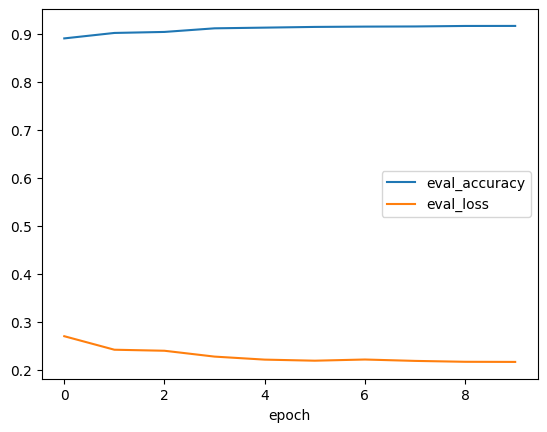

In [18]:
trainer_qlora.save_model("./lora_final_model")
log_history_qlora = trainer_qlora.state.log_history
get_metric_qlora = lambda metric, log_history_qlora: [log[metric] for log in log_history_qlora if metric in log]
eval_accuracy_qlora=get_metric_qlora('eval_accuracy',log_history_qlora)
eval_loss_qlora=get_metric_qlora('eval_loss',log_history_qlora)
plt.plot(eval_accuracy_qlora,label='eval_accuracy')
plt.plot(eval_loss_qlora,label='eval_loss')
plt.xlabel("epoch")
plt.legend()